
# All-Day Breakfast (ADB) — EDA, Pre/Post Tests, Attribute Analyses, and Maps 

This notebook performs:
- **Merge** Restaurant Facts and Weekly Sales on `REST_KEY`
- **Infer** global ADB launch date from “Total All Day Breakfast Items” time series
- **Outlier identification only** (no smoothing/replacement); retain `*_IS_OUTLIER` flags
- **Descriptive Statistics** (overall, pre/post ADB, by category)
- **YoY trend plots** for **URWS** and **AGC** (raw values)
- **Hypothesis testing**: pre/post t-tests, category cannibalization OLS, DiD
- **Geospatial maps (folium)**: two layers showing **pre→post change** by store for **URWS** and **AGC**
- **Attribute-based analysis** using columns from Restaurant Facts (e.g., segment labels)



### Read in data and combine data sources

In [1]:

# --- Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# Geospatial
import folium
from folium.plugins import MarkerCluster

%matplotlib inline

# --- Parameters ---
FACTS_PATH = Path("McD Restaurant Facts.csv")
SALES_PATH = Path("McD Weekly Sales.csv")
DATA_DICT_PATH = Path("McD Data Dictionary.xlsx")  # optional

OUTPUT_MERGED_CSV = Path("merged_store_week_dataset_no_smoothing.csv")
OUTPUT_MAP_HTML = Path("store_change_map_URWS_AGC.html")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [2]:

# --- Load ---
facts = pd.read_csv(FACTS_PATH)
sales = pd.read_csv(SALES_PATH)

def normalize_cols(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
        .str.replace(r"_+", "_", regex=True)
        .str.strip("_")
    )
    return df

facts = normalize_cols(facts)
sales = normalize_cols(sales)

print("FACTS columns (first 25):", list(facts.columns)[:25])
print("SALES columns (first 25):", list(sales.columns)[:25])

display(facts.head(3))
display(sales.head(3))


FACTS columns (first 25): ['rest_key', 'rest_label', 'city', 'zip', 'state', 'county', 'latitude', 'longitude', 'rest_plypl_typ', 'rest_drv_thru_typ', 'rest_type', 'owner_label', 'trad_label', 'subtype_label', 'incomeq_label', 'urban_label', 'social_label', 'lstage_label', 'ppop_09q_label', 'pgrowthq_label']
SALES columns (first 25): ['rest_key', 'itemn', 'itemdesc', 'wk_ending', 'urws', 'wavg_price', 'upt', 'agc', 'adus', 'totunits']


,rest_key,rest_label,city,zip,state,county,latitude,longitude,rest_plypl_typ,rest_drv_thru_typ,rest_type,owner_label,trad_label,subtype_label,incomeq_label,urban_label,social_label,lstage_label,ppop_09q_label,pgrowthq_label
0,36277,36277-WYOMING - CHICAGO AND GODFREY,WYOMING,49519,MI,KENT MI,42.935777,-85.694556,NONE,SIDE BY SIDE 2 BOOTH,FREESTANDING,LICENSEE,Y,Traditional,NaN,NaN,NaN,NaN,NaN,NaN
1,36302,36302-GRANDVILLE - RIVERTOWN & IVANREST,GRANDVILLE,49418,MI,KENT MI,42.884165,-85.738159,NONE,SIDE BY SIDE 2 BOOTH,FREESTANDING,LICENSEE,Y,Traditional,NaN,NaN,NaN,NaN,NaN,NaN
2,26114,26114-OSHTEMO TOWNSHIP,KALAMAZOO,49009,MI,KALAMAZOO MI,42.296384,-85.683582,NaN,2 BOOTH COD,FREESTANDING,LICENSEE,Y,Traditional,1-Highest Income,4-Town and Rural,11 T1- Landed Gentry,01 Y1- Midlif Success,4-2ndLowest PPop_0_9,1-Highest Pgrowth


,rest_key,itemn,itemdesc,wk_ending,urws,wavg_price,upt,agc,adus,totunits
0,117,1,Total All Day Breakfast Items,1/10/15,4487.0,1.42,583.8,1098.0,641.0,4487.0
1,248,1,Total All Day Breakfast Items,1/10/15,4328.0,1.51,548.9,1126.4,618.3,4328.0
2,958,1,Total All Day Breakfast Items,1/10/15,4326.0,1.44,654.2,944.7,618.0,4326.0


In [3]:

# --- Merge ---
date_col = "wk_ending"
cat_col = "itemdesc"
key_col = "rest_key"

sales[date_col] = pd.to_datetime(sales[date_col], errors="coerce", )
sales = sales.dropna(subset=[date_col])

merged = sales.merge(facts, on=key_col, how="left")

rename_map = {
    "urws": "URWS",
    "adus": "ADUS",
    "upt": "UPT",
    "wavg_price": "WAVG_PRICE",
    "agc": "AGC",
    cat_col: "CATEGORY",
    date_col: "WK_ENDING",
    key_col: "RESTAURANT_ID"
}
merged = merged.rename(columns=rename_map)

merged["WK_ENDING"] = pd.to_datetime(merged["WK_ENDING"])
merged["year"] = merged["WK_ENDING"].dt.year
merged["weekofyear"] = merged["WK_ENDING"].dt.isocalendar().week.astype(int)

display(merged.head(5))
print("Rows:", len(merged), "| Unique stores:", merged["RESTAURANT_ID"].nunique())


/var/folders/_f/hqh752t53tg1jmq2wwf1m7jh0000gn/T/ipykernel_4593/1519418904.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sales[date_col] = pd.to_datetime(sales[date_col], errors="coerce", )


,RESTAURANT_ID,itemn,CATEGORY,WK_ENDING,URWS,WAVG_PRICE,UPT,AGC,ADUS,totunits,...,trad_label,subtype_label,incomeq_label,urban_label,social_label,lstage_label,ppop_09q_label,pgrowthq_label,year,weekofyear
0,117,1,Total All Day Breakfast Items,2015-01-10,4487.0,1.42,583.8,1098.0,641.0,4487.0,...,Y,Traditional,4-2ndLowest Income,1-Urban,02 U2- Midtown Mix,06 F3- Mainstrm Families,1-Highest PPop_0_9,5-Lowest Pgrowth,2015,2
1,248,1,Total All Day Breakfast Items,2015-01-10,4328.0,1.51,548.9,1126.4,618.3,4328.0,...,Y,Traditional,3-Mid Income,2-Suburban,07 S4- Inner Subs,10 M3- Cautious Couples,3-Mid PPop_0_9,5-Lowest Pgrowth,2015,2
2,958,1,Total All Day Breakfast Items,2015-01-10,4326.0,1.44,654.2,944.7,618.0,4326.0,...,Y,Traditional,4-2ndLowest Income,2-Suburban,06 S3- Middleburbs,06 F3- Mainstrm Families,2-2ndHighest PPop_0_9,5-Lowest Pgrowth,2015,2
3,981,1,Total All Day Breakfast Items,2015-01-10,2998.0,1.40,517.9,827.0,428.3,2998.0,...,Y,Traditional,5-Lowest Income,2-Suburban,07 S4- Inner Subs,03 Y3- Strivng Singles,1-Highest PPop_0_9,5-Lowest Pgrowth,2015,2
4,1312,1,Total All Day Breakfast Items,2015-01-10,5090.0,1.48,597.1,1217.7,727.1,5090.0,...,Y,Traditional,4-2ndLowest Income,2-Suburban,07 S4- Inner Subs,10 M3- Cautious Couples,3-Mid PPop_0_9,4-2ndLowest Pgrowth,2015,2


Rows: 307125 | Unique stores: 65


### Assume All-Day Breakfast began in week 40 of 2015

In [4]:
# --- Infer global ADB launch (fixed to ISO week 40 of 2015) ---
# Keeps downstream variables identical: LAUNCH_DATE (datetime64[ns]) and ADB_ACTIVE (0/1)

import pandas as pd
from datetime import date

# Target = ISO week 40 of 2015, Sunday (week-ending)
target_dt = pd.Timestamp(date.fromisocalendar(2015, 40, 7))  # 2015-10-04 (ISO week 40 Sunday)

# Snap to the closest available WK_ENDING in the dataset to avoid misalignment
wk_vals = pd.to_datetime(merged["WK_ENDING"]).dropna().unique()
if len(wk_vals) > 0:
    # Convert to pandas Timestamps for safe arithmetic
    wk_vals_ts = pd.to_datetime(wk_vals)
    global_launch = min(wk_vals_ts, key=lambda d: abs(d - target_dt))
else:
    # Fallback (shouldn't happen if WK_ENDING is populated)
    global_launch = target_dt

# Assign constant launch date and ADB flag
merged["LAUNCH_DATE"] = pd.to_datetime(global_launch)
merged["ADB_ACTIVE"] = (merged["WK_ENDING"] >= merged["LAUNCH_DATE"]).astype(int)

print("Inferred global ADB launch date (fixed to ISO week 40, 2015):", pd.to_datetime(global_launch).date())


Inferred global ADB launch date (fixed to ISO week 40, 2015): 2015-10-03


### Checking for Outliers

In [5]:

# --- Outlier identification only (NO smoothing) ---
def flag_outliers(df, value_col, group_cols, z_thresh=5.0):
    df = df.sort_values("WK_ENDING").copy()
    def _flag(g):
        x = g[value_col].astype(float)
        med = x.median()
        mad = (np.abs(x - med)).median()
        if mad == 0:
            z = pd.Series(np.zeros(len(x)), index=x.index)
        else:
            z = 0.6745 * (x - med) / mad
        g[f"{value_col}_IS_OUTLIER"] = (z.abs() > z_thresh).astype(int)
        return g
    return df.groupby(group_cols, group_keys=False).apply(_flag)

group_cols = ["RESTAURANT_ID"] + (["CATEGORY"] if "CATEGORY" in merged.columns else [])
for v in ["URWS", "AGC"]:
    if v in merged.columns:
        merged = flag_outliers(merged, v, group_cols)

flags = [c for c in ["URWS_IS_OUTLIER", "AGC_IS_OUTLIER"] if c in merged.columns]
if flags:
    outlier_summary = (merged.groupby("RESTAURANT_ID")[flags]
                       .mean()
                       .sort_values(flags, ascending=False))
    display(outlier_summary.head(10))


/var/folders/_f/hqh752t53tg1jmq2wwf1m7jh0000gn/T/ipykernel_4593/41830137.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(_flag)
/var/folders/_f/hqh752t53tg1jmq2wwf1m7jh0000gn/T/ipykernel_4593/41830137.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(_flag)


,URWS_IS_OUTLIER,AGC_IS_OUTLIER
RESTAURANT_ID,,
2308,0.009947,0.000000
1312,0.008254,0.000000
13014,0.008042,0.000000
13776,0.007831,0.000000
16729,0.007831,0.000000
2661,0.007196,0.000000
5238,0.006561,0.005291
958,0.006349,0.000000
36302,0.006349,0.000000


### Compute basic descriptive statistics

In [6]:

# --- Descriptive statistics ---
key_cols = [c for c in ["URWS", "ADUS", "UPT", "WAVG_PRICE", "AGC"] if c in merged.columns]

overall_desc = merged[key_cols].describe().T
display(overall_desc)

prepost = merged.groupby("ADB_ACTIVE")[key_cols].describe().stack(level=0).T
display(prepost)

if "CATEGORY" in merged.columns:
    bycat_desc = merged.groupby("CATEGORY")[key_cols].describe()
    display(bycat_desc)


,count,mean,std,min,25%,50%,75%,max
URWS,302363.0,1385.288071,1686.109154,3.00,265.00,645.00,1790.00,13217.00
ADUS,302363.0,198.710101,241.536347,1.00,38.10,92.70,257.10,1888.10
UPT,302363.0,150.584539,173.964196,1.30,29.60,70.30,194.40,1268.00
WAVG_PRICE,302363.0,2.253482,0.989277,0.51,1.25,2.23,2.99,5.53
AGC,302363.0,1327.253945,332.851216,293.70,1085.30,1316.10,1556.90,2670.00


/var/folders/_f/hqh752t53tg1jmq2wwf1m7jh0000gn/T/ipykernel_4593/1191348820.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  prepost = merged.groupby("ADB_ACTIVE")[key_cols].describe().stack(level=0).T


ADB_ACTIVE              0                                               \
                     ADUS            AGC            UPT           URWS   
count       226364.000000  226364.000000  226364.000000  226364.000000   
mean           197.317556    1354.334597     146.363179    1375.910666   
std            240.184989     335.239759     169.343892    1677.075699   
min              2.600000     303.400000       3.000000       3.000000   
25%             38.100000    1110.300000      29.200000     265.000000   
50%             90.000000    1339.700000      67.000000     627.000000   
75%            253.100000    1597.000000     186.600000    1766.000000   
max           1538.400000    2670.000000    1268.000000   10769.000000   

ADB_ACTIVE                            1                              \
               WAVG_PRICE          ADUS           AGC           UPT   
count       226364.000000  75999.000000  75999.000000  75999.000000   
mean             2.217170    202.857817   1246.593876    163.157917   
std              0.979666    245.472111    312.006182    186.486708   
min              0.510000      1.000000    293.700000      1.300000   
25%              1.190000     38.100000    996.000000     30.800000   
50%              2.210000     99.900000   1257.400000     82.400000   
75%              2.990000    271.100000   1461.000000    237.300000   
max              5.530000   1888.100000   2297.200000    984.400000   

ADB_ACTIVE                              
                    URWS    WAVG_PRICE  
count       75999.000000  75999.000000  
mean         1413.218792      2.361635  
std          1712.440060      1.009664  
min             7.000000      0.720000  
25%           266.000000      1.290000  
50%           694.000000      2.310000  
75%          1887.000000      3.090000  
max         13217.000000      4.490000

URWS                                   \
                                 count         mean          std    min   
CATEGORY                                                                  
Bac Egg Ch Biscuit             11966.0   192.522063    63.359927    9.0   
Bac Egg Ch McGriddle           11966.0    81.458884    27.893706    3.0   
Beef Category                  12155.0  4823.648540  1297.148916  363.0   
Big Mac                        12155.0   505.450267   193.713518   22.0   
Cheeseburger                   12155.0  1054.377951   301.208490  104.0   
Chicken Category               12155.0  3335.134183  1096.828224  285.0   
Core QP and QPC                12155.0   506.911724   162.940003   54.0   
Egg McMuffin                   12155.0   372.989716   144.905773   41.0   
Hamburger                      12155.0   290.487947    87.820600   22.0   
Hashbrown                      12155.0  1851.394406   591.169723  145.0   
Large Burgers                  12155.0  1153.380502   345.811962   92.0   
McChicken                      12155.0  1181.667215   477.262410   88.0   
McDouble                       12155.0  1320.580831   602.439664   66.0   
Sau Egg Ch McGriddle           11966.0   129.514541    42.049463   14.0   
Sausage Biscuit                11966.0   251.429383    82.797301   21.0   
Sausage Egg Biscuit            11966.0    86.463898    27.856110    5.0   
Sausage Egg McMuffin           12155.0   645.118305   240.982955   35.0   
Sausage McMuffin               12155.0   675.486466   234.608743   51.0   
Total All Day Breakfast Items  12155.0  5461.677170  1670.180676  408.0   
Total Bagels                   11966.0   260.430094    80.621321   27.0   
Total Biscuits                 11966.0   617.223216   180.697787   39.0   
Total Breakfast Sandwich       12155.0  3004.770876   915.854600  238.0   
Total Fries                    12155.0  4542.574167  1255.155462  370.0   
Total McGriddles               11966.0   292.829141    89.314371   32.0   
Total McMuffins                12155.0  1852.087783   603.009029  139.0   

                                                                   ADUS  \
                                  25%     50%     75%      max    count   
CATEGORY                                                                  
Bac Egg Ch Biscuit              143.0   189.0   236.0    441.0  11966.0   
Bac Egg Ch McGriddle             61.0    79.0    98.0    234.0  11966.0   
Beef Category                  3918.0  4752.0  5626.5  10633.0  12155.0   
Big Mac                         375.0   464.0   598.0   3340.0  12155.0   
Cheeseburger                    843.0  1033.0  1228.0   3534.0  12155.0   
Chicken Category               2607.5  3272.0  3971.5   9739.0  12155.0   
Core QP and QPC                 393.5   489.0   594.0   2125.0  12155.0   
Egg McMuffin                    267.0   353.0   451.0   1309.0  12155.0   
Hamburger                       225.0   284.0   350.0   1219.0  12155.0   
Hashbrown                      1442.5  1818.0  2228.0   4653.0  12155.0   
Large Burgers                   912.0  1116.0  1348.0   4496.0  12155.0   
McChicken                       847.0  1119.0  1450.0   3481.0  12155.0   
McDouble                        887.0  1215.0  1672.0   5166.0  12155.0   
Sau Egg Ch McGriddle             98.0   124.0   157.0    312.0  11966.0   
Sausage Biscuit                 194.0   242.0   296.0    926.0  11966.0   
Sausage Egg Biscuit              67.0    84.0   103.0    232.0  11966.0   
Sausage Egg McMuffin            476.0   605.0   764.0   2179.0  12155.0   
Sausage McMuffin                510.0   647.0   820.0   2000.0  12155.0   
Total All Day Breakfast Items  4293.0  5328.0  6474.0  13217.0  12155.0   
Total Bagels                    204.0   250.0   306.0    668.0  11966.0   
Total Biscuits                  483.0   605.0   738.0   1375.0  11966.0   
Total Breakfast Sandwich       2364.0  2947.0  3597.0   7367.0  12155.0   
Total Fries                    3671.0  4538.0  5353.0  101

### Plot YoY Trends

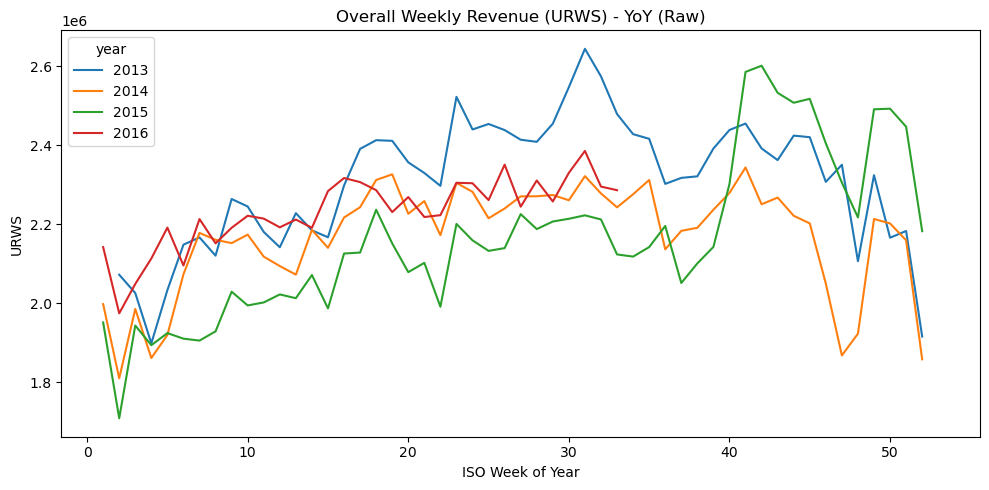

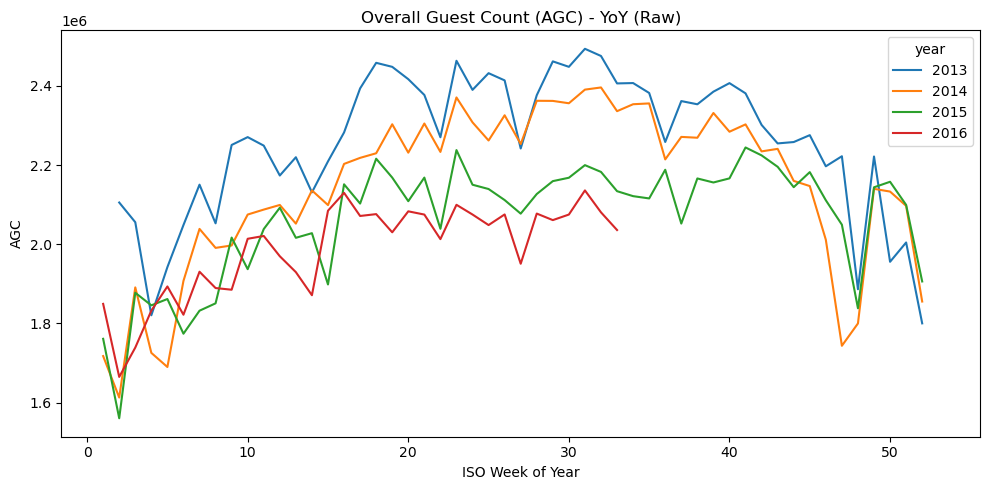

In [7]:

# --- YoY trend plots (raw) ---
def plot_yoy(df, value_col, title):
    if value_col not in df.columns:
        print(f"{value_col} not in dataframe.")
        return
    s = df.groupby(["WK_ENDING"], as_index=False)[value_col].sum().sort_values("WK_ENDING")
    s["year"] = s["WK_ENDING"].dt.year
    s["weekofyear"] = s["WK_ENDING"].dt.isocalendar().week.astype(int)
    pivot = s.pivot_table(index="weekofyear", columns="year", values=value_col, aggfunc="sum")
    ax = pivot.plot(figsize=(10,5))
    ax.set_title(title)
    ax.set_xlabel("ISO Week of Year")
    ax.set_ylabel(value_col)
    plt.tight_layout()
    plt.show()

plot_yoy(merged, "URWS", "Overall Weekly Revenue (URWS) - YoY (Raw)")
plot_yoy(merged, "AGC", "Overall Guest Count (AGC) - YoY (Raw)")



### Hypothesis Testing (Pre/Post, Uplift & Cannibalization)


In [8]:

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- Pre/Post t-tests (market level) ---
metrics = ["URWS", "AGC"]
results = []
for m in metrics:
    if m not in merged.columns:
        continue
    pre = merged.loc[merged["ADB_ACTIVE"] == 0, m].dropna()
    post = merged.loc[merged["ADB_ACTIVE"] == 1, m].dropna()
    t_stat, p_val = stats.ttest_ind(post, pre, equal_var=False)
    results.append({"metric": m, "pre_mean": pre.mean(), "post_mean": post.mean(), "t_stat": t_stat, "p_value": p_val})
prepost_tests = pd.DataFrame(results)
display(prepost_tests)

# --- Cannibalization: category interaction ---
merged["log_URWS"] = np.log1p(merged["URWS"].clip(lower=0.1))
cat_week = (merged.groupby(["WK_ENDING", "CATEGORY", "ADB_ACTIVE"], as_index=False)
            [["URWS", "AGC", "UPT", "WAVG_PRICE"]].mean())
cat_week["log_URWS"] = np.log1p(cat_week["URWS"].clip(lower=0.1))

model = smf.ols("log_URWS ~ ADB_ACTIVE * C(CATEGORY) + WAVG_PRICE", data=cat_week).fit(cov_type="HC3")
print(model.summary())

# --- Difference-in-Differences (ADB vs. Non-ADB categories) ---
merged["IS_ADB_CAT"] = merged["CATEGORY"].str.contains("All Day Breakfast", case=False, na=False).astype(int)
did_model = smf.ols("log_URWS ~ ADB_ACTIVE * IS_ADB_CAT + WAVG_PRICE", data=merged.sample(min(50000, len(merged)), random_state=RANDOM_SEED)).fit(cov_type="HC3")
print(did_model.summary())


,metric,pre_mean,post_mean,t_stat,p_value
0,URWS,1375.910666,1413.218792,5.223648,1.757048e-07
1,AGC,1354.334597,1246.593876,-80.814311,0.000000e+00


                            OLS Regression Results                            
Dep. Variable:               log_URWS   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.511e+04
Date:                Tue, 14 Oct 2025   Prob (F-statistic):               0.00
Time:                        04:39:17   Log-Likelihood:                 3365.7
No. Observations:                4725   AIC:                            -6629.
Df Residuals:                    4674   BIC:                            -6300.
Df Model:                          50                                         
Covariance Type:                  HC3                                         
                                                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------


### 🗺️ Performance Map (R/Y/G Dots, Inline — Composite of ΔURWS & ΔAGC)

This second map renders **inline** and shows **dots** colored by overall performance:
- **Green** = top 33% (best performers)
- **Yellow** = middle 33%
- **Red** = bottom 33% (worst performers)

The composite score is the mean of z-scored ΔURWS and ΔAGC at the **store** level.


In [9]:

import folium
import numpy as np

# Recompute store-level deltas & composite if needed
store_pre = (merged.loc[merged["ADB_ACTIVE"]==0]
             .groupby("RESTAURANT_ID")[["URWS","AGC"]].mean()
             .add_suffix("_pre"))
store_post = (merged.loc[merged["ADB_ACTIVE"]==1]
              .groupby("RESTAURANT_ID")[["URWS","AGC"]].mean()
              .add_suffix("_post"))
store_lvl2 = store_pre.join(store_post, how="outer")

for col in ["URWS","AGC"]:
    store_lvl2[f"{col}_delta"] = store_lvl2.get(f"{col}_post", np.nan) - store_lvl2.get(f"{col}_pre", np.nan)

def zscore(s):
    s = s.astype(float)
    mu = s.mean(skipna=True)
    sd = s.std(ddof=1, skipna=True)
    if not np.isfinite(sd) or sd == 0:
        med = s.median(skipna=True)
        mad = (np.abs(s - med)).median(skipna=True)
        sd = 1.4826 * mad if mad and mad > 0 else 1.0
        mu = med
    return (s - mu) / sd

store_lvl2["URWS_z"] = zscore(store_lvl2["URWS_delta"])
store_lvl2["AGC_z"] = zscore(store_lvl2["AGC_delta"])
store_lvl2["composite_score"] = store_lvl2[["URWS_z","AGC_z"]].mean(axis=1)

# Coordinates from facts
lat_col_candidates = [c for c in facts.columns if c in ["lat", "latitude", "rest_lat", "y"]]
lon_col_candidates = [c for c in facts.columns if c in ["lon", "lng", "longitude", "rest_lon", "x"]]
lat_col = lat_col_candidates[0] if lat_col_candidates else None
lon_col = lon_col_candidates[0] if lon_col_candidates else None

coords = facts.set_index("rest_key")[[lat_col, lon_col]] if (lat_col and lon_col and "rest_key" in facts.columns) else pd.DataFrame()
coords = coords.rename(columns={lat_col:"lat", lon_col:"lon"})
store_lvl2 = store_lvl2.join(coords.rename_axis("RESTAURANT_ID"), how="left")

valid2 = store_lvl2.dropna(subset=["lat","lon","composite_score"]).copy()
q1, q2 = np.nanpercentile(valid2["composite_score"], [33.33, 66.67])
def perf_color(v):
    if v <= q1: return "red"
    if v <= q2: return "yellow"
    return "green"

center_lat = valid2["lat"].mean() if not valid2.empty else 39.5
center_lon = valid2["lon"].mean() if not valid2.empty else -98.35

m_perf = folium.Map(location=[center_lat, center_lon], zoom_start=5, control_scale=False, prefer_canvas=True)
m_perf.options["scrollWheelZoom"] = False

for rid, r in valid2.iterrows():
    color = perf_color(r["composite_score"])
    popup = folium.Popup(html=f"""
        <b>Store:</b> {rid}<br>
        <b>ΔURWS:</b> {r.get('URWS_delta', float('nan')):,.0f}<br>
        <b>ΔAGC:</b> {r.get('AGC_delta', float('nan')):,.0f}<br>
        <b>Composite (z):</b> {r.get('composite_score', float('nan')):.2f}
    """, max_width=280)
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],
        radius=5.5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.85
    ).add_to(m_perf).add_child(popup)

# Legend
legend_html = '''
<div style="position: fixed; bottom: 20px; left: 20px; width: 180px; background: white; border: 1px solid #ccc; padding: 8px; z-index:9999; font-size:14px;">
<b>Overall Performance</b><br>
<span style="background:red; padding:4px 10px; margin-right:6px;"></span> Red = Bottom third<br>
<span style="background:yellow; padding:4px 10px; margin-right:6px;"></span> Yellow = Middle third<br>
<span style="background:green; padding:4px 10px; margin-right:6px;"></span> Green = Top third
</div>
'''
m_perf.get_root().html.add_child(folium.Element(legend_html))
m_perf



### PRIZM / Attribute Correlations with Sales & Performance Changes

We encode PRIZM-like attributes from the Facts table and correlate them with **store-level performance deltas**:
- ΔURWS, ΔAGC, and % changes as available.
We then visualize the correlations as a **heatmap**.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Choose which PRIZM attributes to analyze
prizm_cols = [c for c in ["lstage_label", "urban_label", "ppop_09q_label", "pgrowthq_label"] if c in facts.columns]

# Merge store-level performance deltas with attributes
store_perf_attrs = store_lvl2.reset_index().merge(
    facts.rename(columns={"rest_key":"RESTAURANT_ID"}), on="RESTAURANT_ID", how="left"
)

# Calculate mean and std dev of deltas by PRIZM categories
summary_list = []
for col in prizm_cols:
    tmp = (
        store_perf_attrs.groupby(col)[["URWS_delta", "AGC_delta"]]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    tmp["attribute"] = col
    summary_list.append(tmp)

prizm_summary = pd.concat(summary_list, ignore_index=True)
prizm_summary.columns = [col[0] if col[1] == "" else f"{col[0]}_{col[1]}" for col in prizm_summary.columns]


/var/folders/_f/hqh752t53tg1jmq2wwf1m7jh0000gn/T/ipykernel_4593/905284762.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


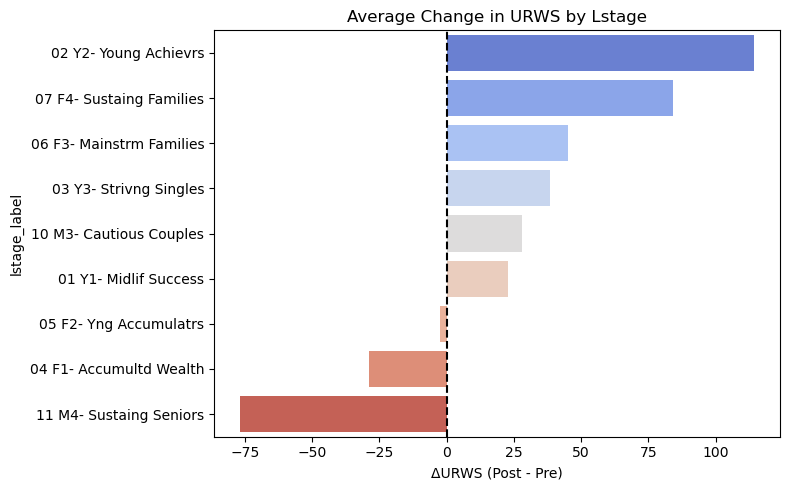

/var/folders/_f/hqh752t53tg1jmq2wwf1m7jh0000gn/T/ipykernel_4593/905284762.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


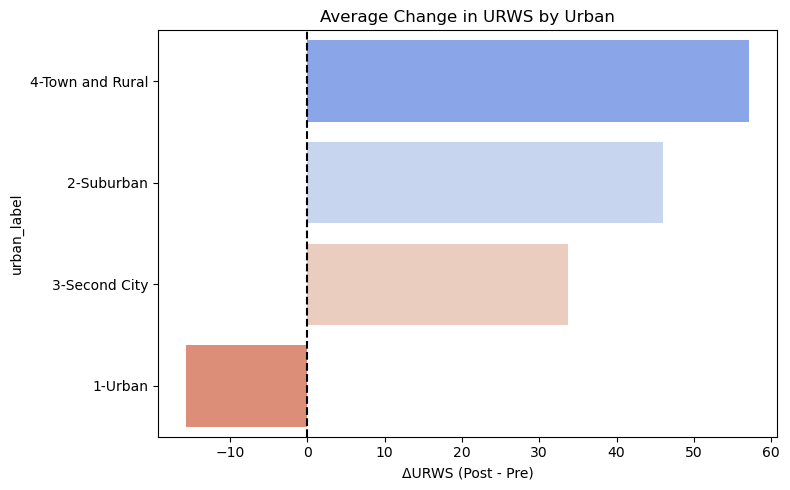

/var/folders/_f/hqh752t53tg1jmq2wwf1m7jh0000gn/T/ipykernel_4593/905284762.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


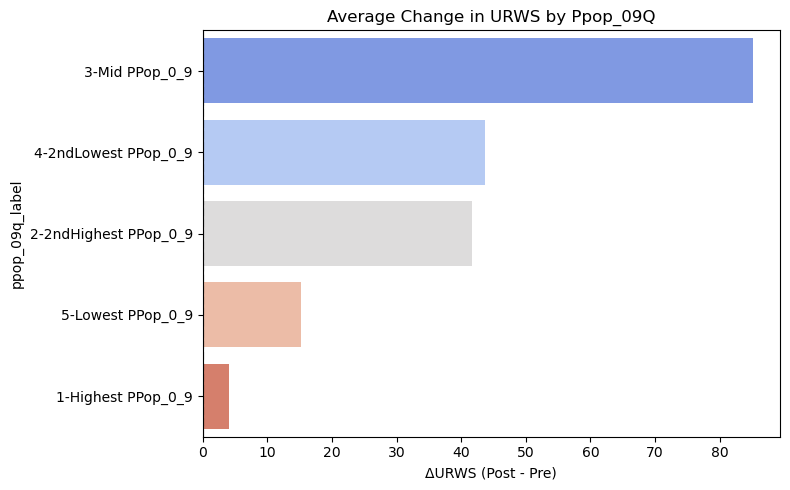

/var/folders/_f/hqh752t53tg1jmq2wwf1m7jh0000gn/T/ipykernel_4593/905284762.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


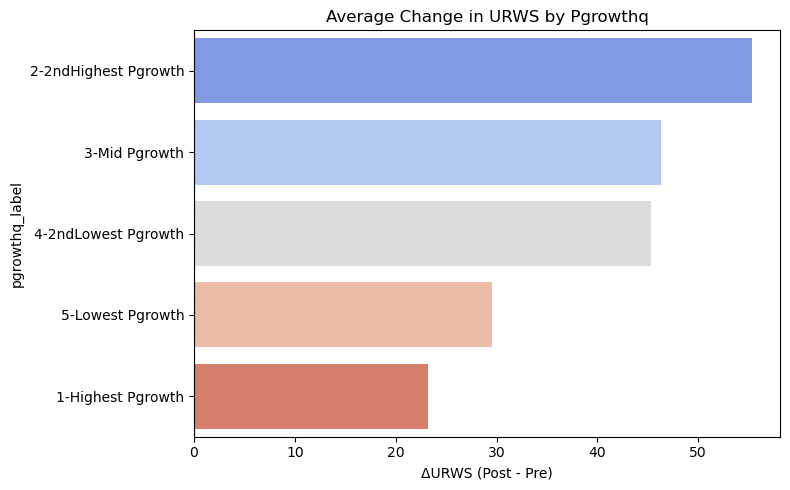

In [11]:
import seaborn as sns

for attr in prizm_cols:
    df_attr = prizm_summary[prizm_summary["attribute"] == attr].copy()
    df_attr = df_attr.sort_values("URWS_delta_mean", ascending=False)
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df_attr,
        x="URWS_delta_mean", y=attr, palette="coolwarm",
        order=df_attr[attr]
    )
    plt.axvline(0, color='k', linestyle='--')
    plt.title(f"Average Change in URWS by {attr.replace('_label','').title()}")
    plt.xlabel("ΔURWS (Post - Pre)")
    plt.ylabel(attr)
    plt.tight_layout()
    plt.show()


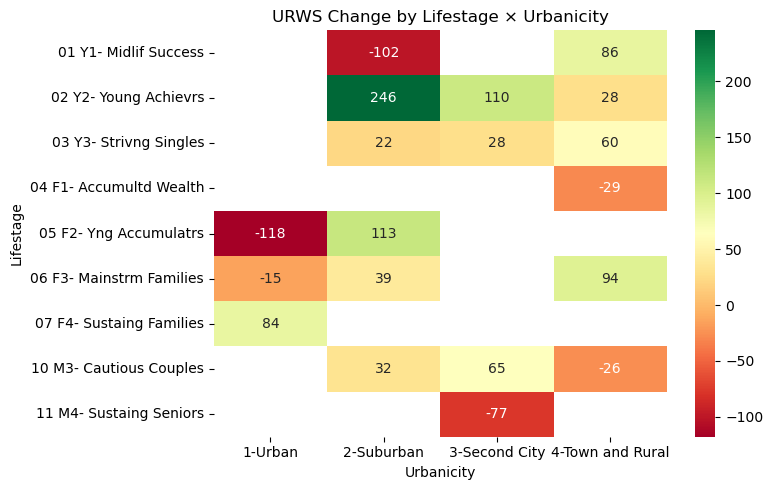

In [12]:
# Cross-tab responsiveness
if "lstage_label" in facts.columns and "urban_label" in facts.columns:
    cross = store_perf_attrs.groupby(["lstage_label", "urban_label"])["URWS_delta"].mean().unstack()
    plt.figure(figsize=(8, 5))
    sns.heatmap(cross, annot=True, fmt=".0f", cmap="RdYlGn")
    plt.title("URWS Change by Lifestage × Urbanicity")
    plt.xlabel("Urbanicity")
    plt.ylabel("Lifestage")
    plt.tight_layout()
    plt.show()
